**Installing all the Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data  = pd.read_csv('hypothyroid.csv')

In [3]:
data.shape

(3772, 30)

In [4]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [5]:
data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


The data description clearly shows that there are no missing values. However, when you look at the dataset, you will notice that the missing values are substituted with invalid values such as '?'. Let us substitute such values with 'nan' and check for missing values again.

**Replacing the Missing Values**

In [6]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        print(column, data[column][data[column]=='?'].count())


age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


These columns have missing values, but '?' is used instead of the missing values. We will substitute these values with 'nan' and then do imputation for the missing values.

Furthermore, we can observe that all the entries for column "TBG" are missing. So we'll remove this column because it's no longer useful to us.


In [7]:
data = data.drop(['TBG'],axis =1)

Also, looking at the dataset, we can see that some columns have true and false values, which simply indicate if the next column has values or not. Let's take an example.


In [8]:
data[['T4U_measured','T4U']]

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


There is no use in having such columns in our dataset because we will always deal with missing values.

Let's remove those columns as well.


In [9]:
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [10]:
# Now let's replace the '?' values with numpy nan
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        data[column] = data[column].replace('?',np.nan)

In [11]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count==0:
        print(column, data[column][data[column]=='?'].count())

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


In [12]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

As the data are categorical, we must convert them to numerical before applying any imputation algorithms.

We can utilise get dummies, but because most of the columns have only two distinct categories, we will map them. Why? Because there are just two categories, the two columns created after getting dummies will both have a high correlation because they explain the same thing. So we'll have to drop one of the columns. That's why we'll utilise mapping for such columns. For columns with more than two categories, we shall utilise get dummy.


In [13]:
# We can map the categorical values like below:
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, let's do a smarter work
for column in data.columns:
    if  len(data[column].unique())==2:
        data[column] = data[column].map({'f' : 0, 't' : 1})

# this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories.


In [14]:
data['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [15]:
# we will use get_dummies with that.
data = pd.get_dummies(data, columns=['referral_source'],drop_first=True)

Our output class is now divided into four categories. It makes no sense to use get dummies with our Output class, therefore we will simply map them. We'll utilise the LabelEncoder function for this.


In [16]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [17]:
lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [18]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,1.3,2.5,125,1.14,109,1,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,...,4.1,2,102,NaN,NaN,1,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,...,0.98,NaN,109,0.91,120,1,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,...,0.16,1.9,175,NaN,NaN,1,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,...,0.72,1.2,61,0.87,70,1,False,False,True,False


In [19]:
data.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3403,3003,3541,3385,3387,3772.000000,3772,3772,3772,3772
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,287,69,241,146,234,NaN,2,2,2,2
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,2,101,0.99,100,NaN,False,False,False,True
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,116,238,71,95,73,NaN,3386,3733,2738,2201
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,NaN,0.974814,NaN,NaN,NaN,NaN
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,NaN,0.279508,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


Great! Now that we have encoded all our Categorical values. Let's start with imputing the missing values.

In [20]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 3, weights='uniform', missing_values = np.nan)
new_array = imputer.fit_transform(data)

new_data = pd.DataFrame(data=np.round(new_array),columns=data.columns)

In [21]:
new_data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.737275,0.307529,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,4.830594,2.027837,108.542153,1.020944,110.363468,0.974814,0.102333,0.010339,0.274125,0.583510
std,20.082478,0.461532,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,23.323891,0.786399,35.009868,0.165546,32.275460,0.279508,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,530.000000,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Great! Now there are no missing values in our new dataset.

Let's check the distribution for our continous data in the dataset:

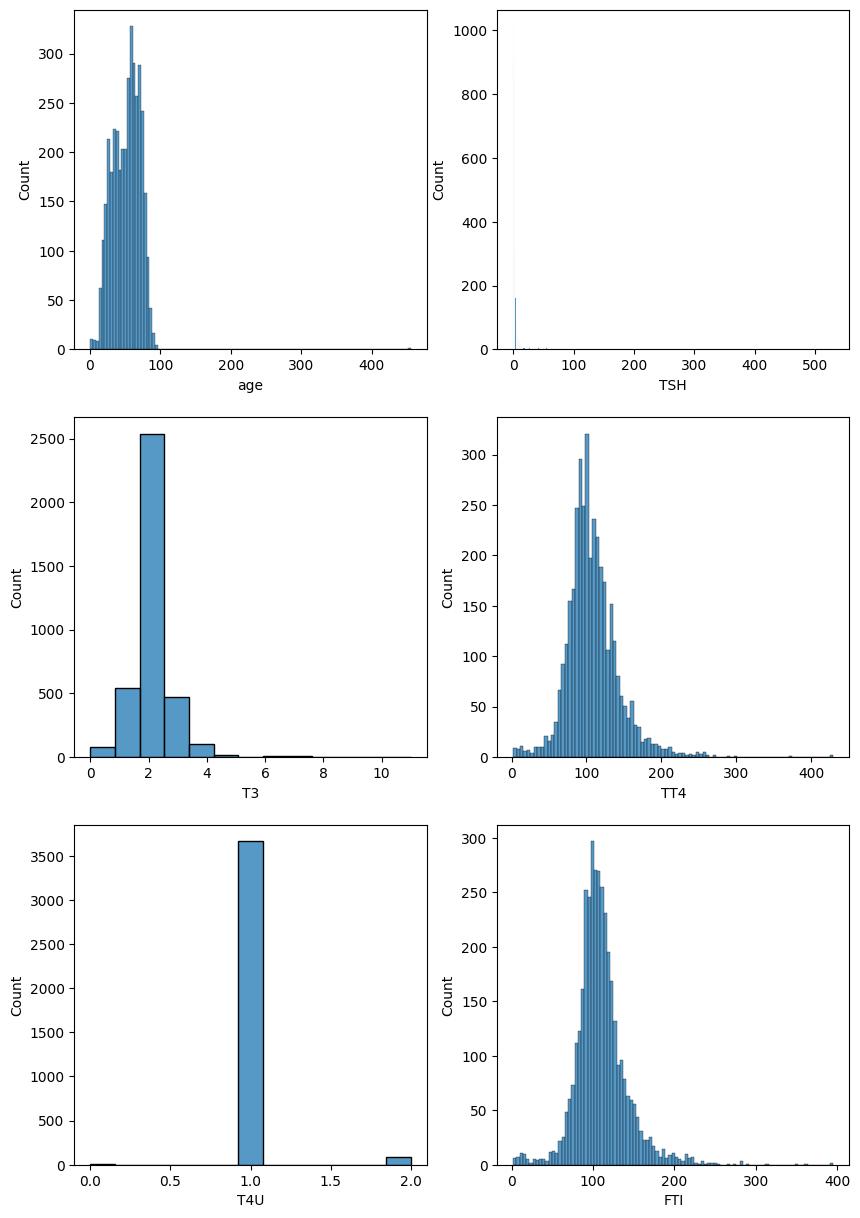

In [23]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plot.subplot(3,2,plotnumber)
    sns.histplot(new_data[column])
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

The graphs for age, TSH and T3 looks heavely skewed towards left. Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

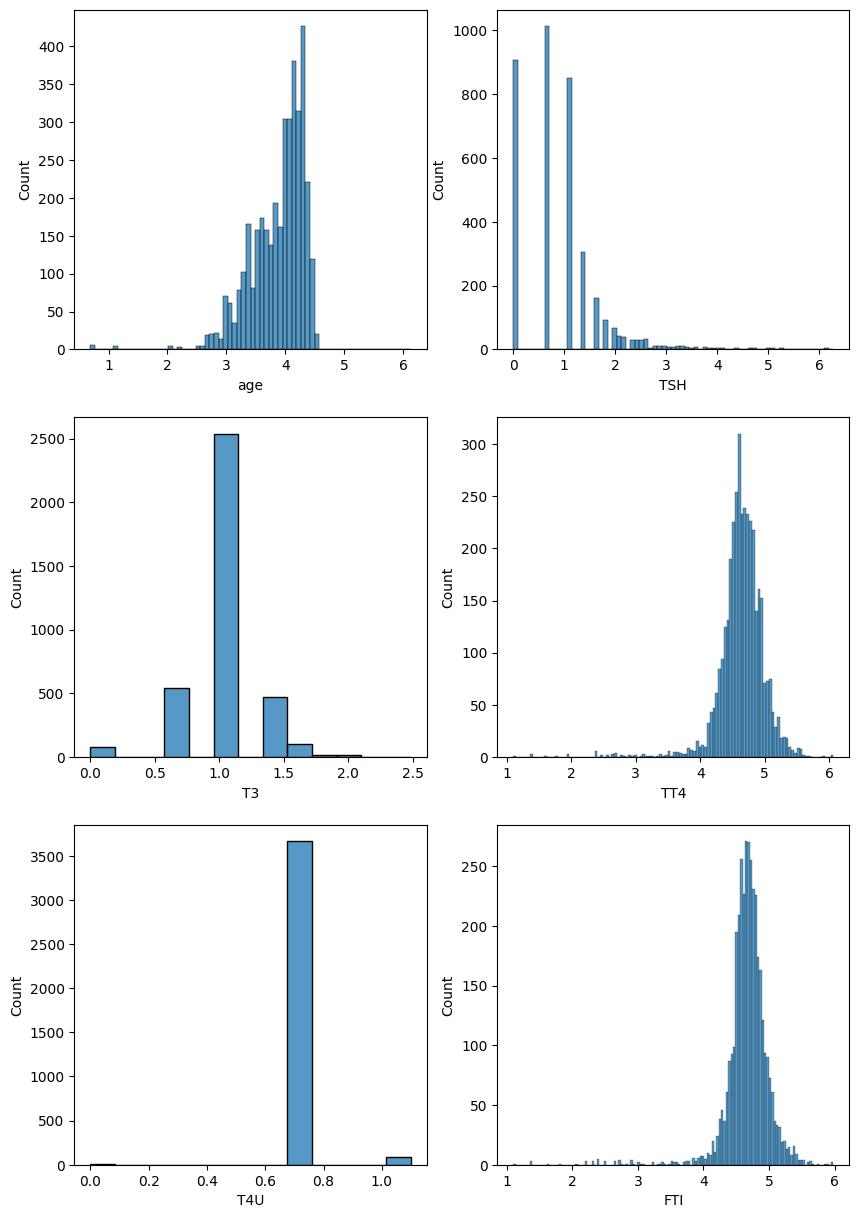

In [24]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plot.subplot(3,2,plotnumber)
    sns.histplot(np.log(new_data[column]))
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

After log transformation, rest of the columns look fine but 'TSH' has a weird trend.

It won't give much of information so let's drop this column.

In [25]:
new_data = new_data.drop(['TSH'],axis=1)

<ipython-input-45-ee43803eac1a>:9: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='Class', data=new_data, palette=custom_colors)


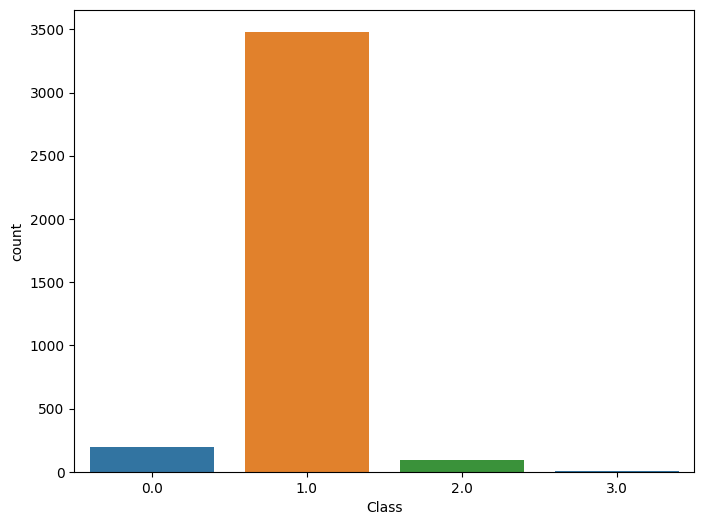

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have new_data defined
# Define custom colors for the first three columns
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=new_data, palette=custom_colors)


plt.show()



We can clerly see that the dataset is highly imbalanced.

We will use a python library known as imbalanced-learn to deal with imbalanced data. Imbalanced learn has an algorithm called RandomOverSampler.

In [37]:
X = new_data.drop(['Class'],axis=1)
y = new_data['Class']
rdsmple = RandomOverSampler()
X_sampled,y_sampled  = rdsmple.fit_resample(X,y)

In [38]:
X_sampled.shape

(13924, 24)

In [39]:
X_sampled = pd.DataFrame(data = X_sampled, columns = X.columns)

In [40]:
X_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,126.0,2.0,110.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0
13920,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0
13921,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0


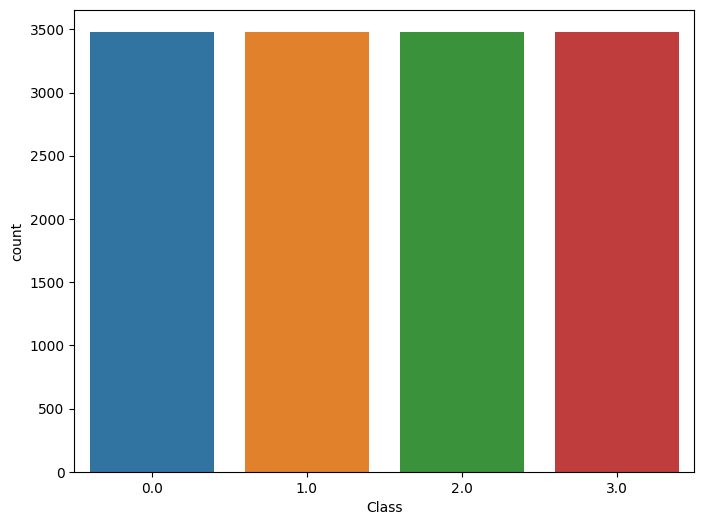

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_sampled is your data
plt.figure(figsize=(8, 6))

# Define custom colors: blue, orange, green, and red
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create the countplot with the custom colors
sns.countplot(x=y_sampled, palette=custom_colors)

plt.show()


Great! Our dataset looks balanced now. We can go ahead with training our model on this data.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
rf_clf = DecisionTreeClassifier(random_state=42)

In [47]:
rf_clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
rf_clf.predict(X_train)

array([1., 1., 1., ..., 1., 1., 1.])

In [49]:
rf_clf.score(X_test, y_test)

0.8834437086092716

In [50]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

# Predict on the test set
model_y_pred = svm_clf.predict(X_test)

In [51]:
svm_clf.score(X_test, y_test)

0.9350993377483444

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

knn_y_pred = knn_clf.predict(X_test)
knn_clf.score(X_test,y_test)

0.9350993377483444

In [53]:
from sklearn.model_selection import cross_val_score

classifiers = [rf_clf, svm_clf, knn_clf]

for classifier in classifiers:
    scores = cross_val_score(classifier, X, y, cv=2)
    print(f"{classifier.__class__.__name__} Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean()}\n")


DecisionTreeClassifier Cross-Validation Scores: [0.89448568 0.88388123]
Mean Accuracy: 0.8891834570519619

SVC Cross-Validation Scores: [0.93319194 0.93584305]
Mean Accuracy: 0.9345174973488866

KNeighborsClassifier Cross-Validation Scores: [0.92788971 0.93372216]
Mean Accuracy: 0.9308059384941676



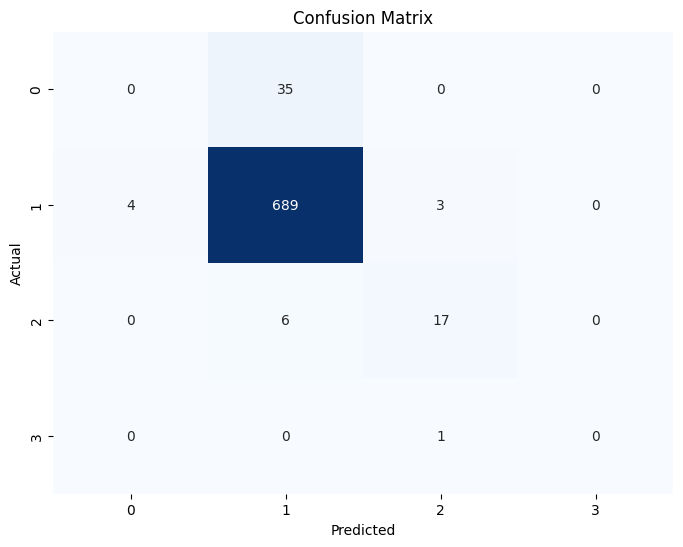

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn_clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()